In [10]:
# setwd("C:/dist/gitlab/lectures/labs/nanostructures_analysis/2018_10_06")
require(ggplot2)
require(tikzDevice)
options(tikzDefaultEngine = 'xetex')

Loading required package: tikzDevice


In [2]:
install.packages('tikzDevice')

also installing the dependencies ‘filehash’, ‘png’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [3]:
# функции ------

make_peak <- function(peak=1, df=A600, limit_min, limit_max, span=0.5) {
  df <- subset(df, theta >= limit_min & theta <= limit_max)
  l_mid <- mean( c( df$l[1], tail(df$l, 1) ) )
  l_max <- subset( df, l == max(df$l) )$l
  l_fwhm <- mean( c(l_mid, l_max) )
  l_predict <- predict( loess(l ~ theta, df, span = span), df )
  
  return(
    do.call(
      rbind, Map(
        data.frame,
        theta = df$theta,
        l = df$l,
        l_max = l_max,
        l_mid = l_mid,
        l_fwhm = l_fwhm,
        l_predict = l_predict,
        peak = as.factor(peak)
      )
    )
  )
}

In [4]:
hightlight_peak <- function(df) {
  limit_min <- min(df$theta); limit_max <- max(df$theta)
  return(
    subset(df,
      theta == limit_min |
      theta == df$theta[df$l == max(df$l)] |
      theta == limit_max
    )
  )
}

In [5]:
calculate_fwhm <- function(df) {
  limit_min <- min(df$theta); limit_max <- max(df$theta)
  theta_max <- subset( df, l == max(df$l) )$theta
  l_fwhm <- df$l_fwhm[1]
  # split df in two halves
  # left
  df_left <- subset(df, theta >= limit_min & theta <= theta_max)
  formula <- loess(l ~ theta, df_left, span = 0.5)
  theta_left <- approx(x = formula$fitted, y = formula$x, xout = l_fwhm)$y

  # right
  df_right <- subset(df, theta >= theta_max & theta <= limit_max)
  formula <- loess(l ~ theta, df_right, span = 0.5)
  theta_right <- approx(x = formula$fitted, y = formula$x, xout = l_fwhm)$y

  fwhm <- theta_right - theta_left

  # predict values in those points
  formula <- loess(l ~ theta, df, span = 0.5)

  return(
    data.frame(
      theta = c(theta_left, theta_right), 
      l = predict( formula, data.frame(theta = c(theta_left, theta_right)) ),
      theta_max = theta_max,
      fwhm = fwhm
    )
  )
}

In [6]:
radians <- function(deg) {(deg * pi) / (180)}

In [7]:
D <- function(FWMH, THETA, k = 0.94, lambda = 0.154) {
  beta <- FWMH * 0.017
  theta <- radians(THETA / 2)
  return((k * lambda) / (beta * cos(theta)))
}

In [8]:
# A600 общий вид -----------

A600 <- read.csv('A600.csv', col.names = c('theta', 'l'))

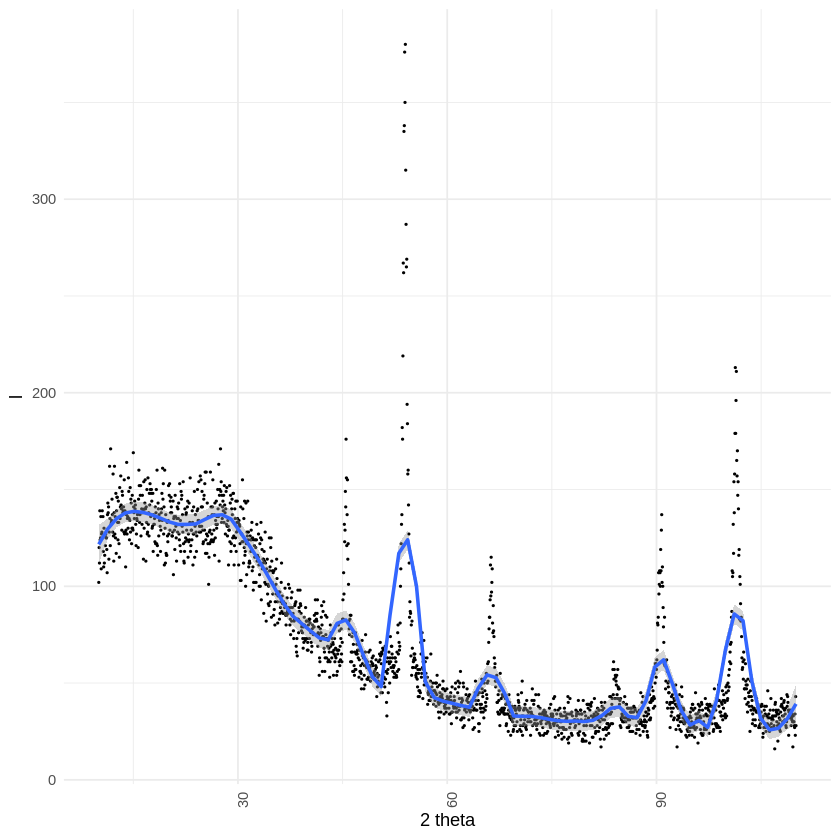

In [11]:
# tikz('_A600_pic_1.tex', width = 6, height = 3)
ggplot(data = A600, aes(x = theta, y = l)) +
  geom_point(size = 0.25) +
  geom_smooth(method = 'loess', span = 0.1) +
  scale_x_continuous(name = '2 theta') +
  scale_y_continuous(name = 'l') +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 0),
        axis.text.y = element_text())
# dev.off()
# ggsave(filename = 'A600_1.png')

In [13]:
# A600 приближение ----
peak_1 <- make_peak(peak = 1, limit_min = 44.50, limit_max = 46.35)
peak_2 <- make_peak(peak = 2, limit_min = 53.05, limit_max = 55.00)
peak_3 <- make_peak(peak = 3, limit_min = 65.70, limit_max = 66.95)
peak_4 <- make_peak(peak = 4, limit_min = 83.50, limit_max = 84.10)
peak_5 <- make_peak(peak = 5, limit_min = 89.45, limit_max = 91.85)
peak_6 <- make_peak(peak = 6, limit_min = 100.25, limit_max = 102.90)

In [14]:
zoom_2 <- rbind(peak_1, peak_2, peak_3, peak_4, peak_5, peak_6)

In [15]:
peak_1_ <- hightlight_peak(peak_1)
peak_2_ <- hightlight_peak(peak_2)
peak_3_ <- hightlight_peak(peak_3)
peak_4_ <- hightlight_peak(peak_4)
peak_5_ <- hightlight_peak(peak_5)
peak_6_ <- hightlight_peak(peak_6)

In [16]:
zoom_2_ <- rbind(peak_1_, peak_2_, peak_3_, peak_4_, peak_5_, peak_6_)

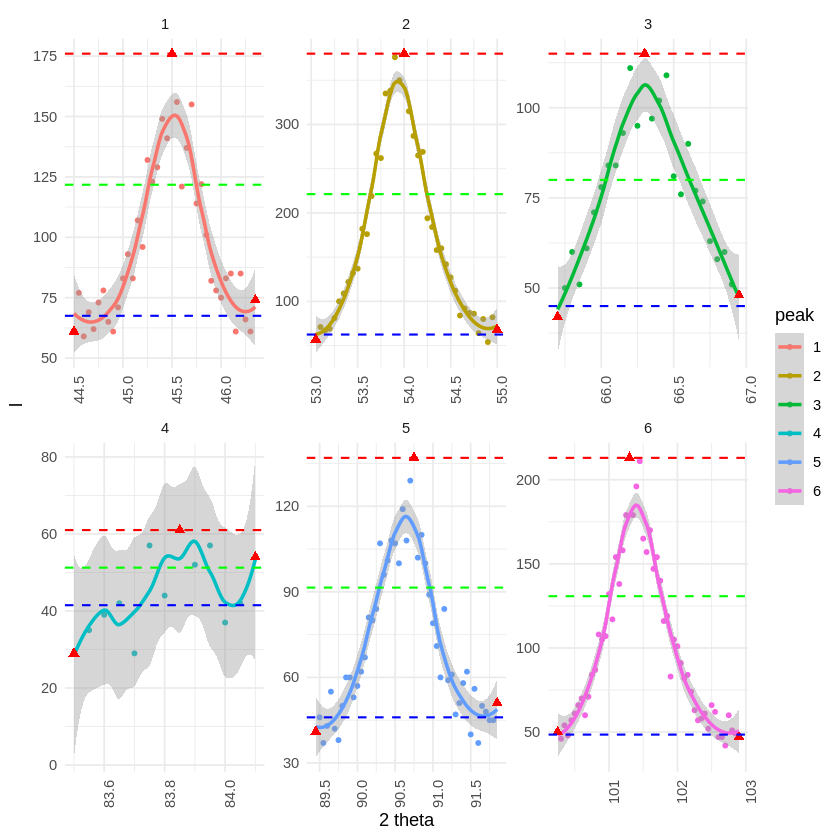

In [18]:
# tikz('_A600_pic_2.tex', width = 6, height = 4)
ggplot(data = zoom_2, aes(x = theta, y = l, color = peak)) +
  facet_wrap(aes(peak), scales = 'free', nrow = 2) +
  geom_point(size = 1) +
  geom_smooth(method = 'loess', span = 0.5, na.rm = T) +
  geom_point(data = zoom_2_, shape = 17,   colour = 'red',   size = 2) +
  geom_hline(aes(yintercept = l_mid),      colour = 'blue',  size = 0.6, linetype="dashed") +
  geom_hline(aes(yintercept = l_fwhm),     colour = 'green', size = 0.6, linetype="dashed") +
  geom_hline(aes(yintercept = l_max),      colour = 'red',   size = 0.6, linetype="dashed") +
  scale_x_continuous(name = '2 theta') +
  scale_y_continuous(name = 'l') +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 0),
        axis.text.y = element_text())
# dev.off()
# ggsave(filename = 'A600_2.png', dpi = 600)

In [58]:
df <- peak_1

In [59]:
limit_min <- min(df$theta); limit_max <- max(df$theta)
theta_max <- subset( df, l == max(df$l) )$theta
l_fwhm <- df$l_fwhm[1]

In [64]:
# split df in two halves
# left
df_ <- subset(df, theta >= limit_min & theta <= theta_max)
formula_left <- loess(l ~ theta, df_, span = 0.5)
theta_left <- approx(x = formula_left$fitted, y = formula_left$x, xout = l_fwhm)

In [73]:
approx(x = formula_left$fitted, y = formula_left$x, xout = l_fwhm)

$x
[1] 121.75

$y
[1] 45.27443

In [74]:
approx(x = formula_right$fitted, y = formula_right$x, xout = l_fwhm)

$x
[1] 121.75

$y
[1] 45.77794

In [65]:
# right
df_ <- subset(df, theta >= theta_max & theta <= limit_max)
formula_right <- loess(l ~ theta, df_, span = 0.5)
theta_right <- approx(x = formula_right$fitted, y = formula_right$x, xout = l_fwhm)

In [103]:
tikz('img/A600_1_1.tex', width = 6, height = 4)
plot(df$theta, df$l, xlab="2 theta", ylab='l')
lines(formula_left$x, formula_left$fitted, col='blue')
lines(formula_right$x, formula_right$fitted, col='green')
abline(v = c(limit_min, limit_max, theta_max), h = c(l_fwhm, df$l_mid, df$l_max), col='gray')

points(c(theta_left$y, theta_right$y), c(theta_left$x, theta_right$x), col='red')
lines(c(theta_left$y, theta_right$y), c(theta_left$x, theta_right$x), col='red')
dev.off()

png 
  2

In [96]:
df$

In [ ]:
fwhm <- theta_right - theta_left

In [19]:
# predict values in those points
formula <- loess(l ~ theta, df, span = 0.5)
predict( formula, data.frame(theta = c(theta_left, theta_right)) )

theta l   l_max l_mid l_fwhm l_predict peak
1  44.50  61 176   67.5  121.75  68.48125 1   
2  44.55  77 176   67.5  121.75  66.71711 1   
3  44.60  59 176   67.5  121.75  65.56249 1   
4  44.65  69 176   67.5  121.75  64.95844 1   
5  44.70  62 176   67.5  121.75  65.01596 1   
6  44.75  73 176   67.5  121.75  65.68559 1   
7  44.80  78 176   67.5  121.75  66.96733 1   
8  44.85  65 176   67.5  121.75  69.05459 1   
9  44.90  61 176   67.5  121.75  71.46225 1   
10 44.95  71 176   67.5  121.75  74.64375 1   
11 45.00  83 176   67.5  121.75  79.52250 1   
12 45.05  93 176   67.5  121.75  85.56418 1   
13 45.10  83 176   67.5  121.75  92.18339 1   
14 45.15 107 176   67.5  121.75 100.43499 1   
15 45.20  96 176   67.5  121.75 109.20633 1   
16 45.25 132 176   67.5  121.75 119.06877 1   
17 45.30 123 176   67.5  121.75 128.42840 1   
18 45.35 129 176   67.5  121.75 136.59956 1   
19 45.40 149 176   67.5  121.75 143.53893 1   
20 45.45 141 176   67.5  121.75 147.50292 1   
21 45.50 176 176   67.5  121.75 150.09493 1   
22 45.55 156 176   67.5  121.75 150.21450 1   
23 45.60 121 176   67.5  121.75 146.82874 1   
24 45.65 137 176   67.5  121.75 141.42486 1   
25 45.70 155 176   67.5  121.75 132.90688 1   
26 45.75 114 176   67.5  121.75 121.38717 1   
27 45.80 122 176   67.5  121.75 111.35803 1   
28 45.85 101 176   67.5  121.75 102.21660 1   
29 45.90  82 176   67.5  121.75  93.60088 1   
30 45.95  78 176   67.5  121.75  87.25448 1   
31 46.00  75 176   67.5  121.75  81.77009 1   
32 46.05  83 176   67.5  121.75  77.27501 1   
33 46.10  85 176   67.5  121.75  73.72449 1   
34 46.15  61 176   67.5  121.75  71.16305 1   
35 46.20  85 176   67.5  121.75  69.68815 1   
36 46.25  66 176   67.5  121.75  69.20861 1   
37 46.30  61 176   67.5  121.75  69.70687 1   
38 46.35  74 176   67.5  121.75  71.17860 1

In [20]:
# A600 расчет диаметров ------

D(FWMH = calculate_fwhm(peak_1)$fwhm[1], THETA = calculate_fwhm(peak_1)$theta[1])
# [1] 18.32337
D(FWMH = calculate_fwhm(peak_2)$fwhm[1], THETA = calculate_fwhm(peak_2)$theta[1])
# [1] 16.42549
D(FWMH = calculate_fwhm(peak_3)$fwhm[1], THETA = calculate_fwhm(peak_3)$theta[1])
# [1] 17.85134
D(FWMH = calculate_fwhm(peak_4)$fwhm[1], THETA = calculate_fwhm(peak_4)$theta[1])
# [1] 82.20816
D(FWMH = calculate_fwhm(peak_5)$fwhm[1], THETA = calculate_fwhm(peak_5)$theta[1])
# [1] 18.32268
D(FWMH = calculate_fwhm(peak_6)$fwhm[1], THETA = calculate_fwhm(peak_6)$theta[1])
# [1] 18.98512

[1] 18.32337

[1] 16.42549

[1] 17.85134

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 83.849”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.10125”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 0.010252”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 83.849”Warning message in simpleLoess(y, x, w, span, degree = degree, parametr

[1] 82.20816

[1] 18.32268

[1] 18.98512

In [21]:
# A123 общий вид --------------

A123 <- read.csv('A123.csv', col.names = c('theta', 'l'))

In [23]:
tikz('_A123_pic_1.tex', width = 6, height = 3)
ggplot(data = A123, aes(x = theta, y = l)) +
  geom_point(size = 0.25) +
  geom_hline(yintercept = mean(A123$l), colour = 'red') +
  geom_smooth(method = 'loess', span = 0.01) +
  theme_minimal() +
  scale_x_continuous(name = "2 theta", limits = c(5, 90), breaks = seq(5, 90, 5)) +
  scale_y_continuous(name = "l", limits = c(60, 600), breaks = seq(60, 600, 50))
dev.off()
# ggsave(filename = 'A123_1.png')

png 
  2

In [24]:
# A123 приближение ----
peak_1 <- make_peak(df = A123, peak = 1, limit_min = 30.5, limit_max = 31.5)
peak_2 <- make_peak(df = A123, peak = 2, limit_min = 35.9, limit_max = 36.8)
peak_3 <- make_peak(df = A123, peak = 3, limit_min = 37.5, limit_max = 38.5)

In [25]:
zoom_2 <- rbind(peak_1, peak_2, peak_3)

In [26]:
peak_1_ <- hightlight_peak(peak_1)
peak_2_ <- hightlight_peak(peak_2)
peak_3_ <- hightlight_peak(peak_3)

In [27]:
zoom_2_ <- rbind(peak_1_, peak_2_, peak_3_)

In [29]:
tikz('_A123_pic_2.tex', width = 6, height = 3)
ggplot(data = zoom_2, aes(x = theta, y = l, color = peak)) +
  facet_wrap(aes(peak), scales = 'free') +
  geom_point(size = 1) +
  geom_smooth(method = 'loess', span = 0.9, na.rm = T) +
  geom_point(data = zoom_2_, shape = 17,   colour = 'red',   size = 2) +
  geom_hline(aes(yintercept = l_mid),      colour = 'blue',  size = 0.6, linetype="dashed") +
  geom_hline(aes(yintercept = l_fwhm),     colour = 'green', size = 0.6, linetype="dashed") +
  geom_hline(aes(yintercept = l_max),      colour = 'red',   size = 0.6, linetype="dashed") +
  scale_x_continuous(name = '2 theta') +
  scale_y_continuous(name = 'l') +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 0),
        axis.text.y = element_text())
dev.off()
# ggsave(filename = 'A123_2.png', dpi = 600)

png 
  2

In [30]:
# A123 расчет диаметров ------

D(FWMH = calculate_fwhm(peak_1)$fwhm[1], THETA = calculate_fwhm(peak_1)$theta[1])
# [1] 50.90857
D(FWMH = calculate_fwhm(peak_2)$fwhm[1], THETA = calculate_fwhm(peak_2)$theta[1])
# [1] 29.3242
D(FWMH = calculate_fwhm(peak_3)$fwhm[1], THETA = calculate_fwhm(peak_3)$theta[1])
# [1] 47.11822

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“Chernobyl! trL>n 8”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“Chernobyl! trL>n 8”Warning message in sqrt(sum.squares/one.delta):
“NaNs produced”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“Chernobyl! trL>n 8”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“Chernobyl! trL>n 8”Warning message in sqrt(sum.squares/one.delta):
“NaNs produced”

[1] 50.90857

[1] 29.3242

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 38.249”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.10125”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 0.010252”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 38.249”Warning message in simpleLoess(y, x, w, span, degree = degree, parametr

[1] 47.11822